In [66]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Loading model...Done! Took 11.379983901977539 seconds
Running inference for /content/TF-2.x-Object-Detection/images/download (4).jpg... Done


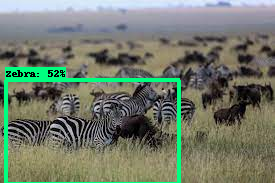

In [68]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# Enable GPU dynamic memory allocation
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/TF-2.x-Object-Detection/images/download (4).jpg'


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/TF-2.x-Object-Detection/inference_graph/'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/TF-2.x-Object-Detection/images/labelmap.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED
